# VQC vs MLP

In [55]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_moons, make_circles
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix
import pandas as pd
from sklearn.metrics import roc_auc_score

In [56]:
results = []

In [57]:
import numpy as np
import torch

def plot_decision_boundary(model, X, y, title, is_torch=False):
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 300),
        np.linspace(y_min, y_max, 300)
    )

    grid = np.c_[xx.ravel(), yy.ravel()]

    if is_torch:
        with torch.no_grad():
            Z = model(torch.tensor(grid, dtype=torch.float32)).numpy()
    else:
        Z = model.predict_proba(grid)[:, 1]

    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(7,5))
    plt.contourf(xx, yy, Z, levels=30, cmap="coolwarm", alpha=0.6)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap="coolwarm", s=25, edgecolor="k")
    plt.title(title)
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.tight_layout()
    plt.show()

In [58]:
def evaluate_mlp(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    return accuracy_score(y_test, model.predict(X_test))

In [59]:
def training_plot(losses: list, title='VQC Training Progress'):
    plt.figure(figsize=(7,5))
    plt.plot(range(1, len(losses) + 1), losses, 'b-', linewidth=2, label='Training Loss')
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.title(title, fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=12)

In [60]:
def plot_roc_curve_elegant(model, X_test, y_test, title='ROC Curve'):
    if hasattr(model, 'predict_proba'):  
        y_scores = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, 'model') and hasattr(model.model, 'eval'):  # VQC модели
        model.model.eval()
        with torch.no_grad():
            y_scores = model.model(torch.tensor(X_test, dtype=torch.float32)).squeeze().numpy()
    else:
        raise ValueError("Неподдерживаемый тип модели")
    
    fpr, tpr, _ = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr, tpr)

    colors = sns.color_palette("husl", 3)    
    plt.figure(figsize=(7, 6))
    sns.set_style("ticks")
    
    # Main ROC curve
    sns.lineplot(x=fpr, y=tpr, color=colors[0], linewidth=2.5, 
                 label=f'AUC = {roc_auc:.3f}')
    
    # Diagonal line
    sns.lineplot(x=[0, 1], y=[0, 1], color=colors[1], linestyle='--', 
                 linewidth=1.5, label='Random')
    
    plt.xlabel('False Positive Rate', fontsize=11)
    plt.ylabel('True Positive Rate', fontsize=11)
    plt.title(title, fontsize=13, pad=15)
    plt.legend(frameon=True, fancybox=True, framealpha=0.8)
    plt.grid(True, alpha=0.3, linestyle='--')
    plt.gca().set_aspect('equal')
    
    sns.despine()
    plt.tight_layout()
    plt.show()
    
    return roc_auc

In [61]:
def plot_confusion_matrix(model, X_test, y_test, title='Confusion Matrix'):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

### Creating Data

**Circles**

In [62]:
X_circles, y_circles = make_circles(
    n_samples=5000,
    noise=0.3,
    factor=0.74,
    random_state=42
)

X_circles = StandardScaler().fit_transform(X_circles)

X_circles_train, X_circles_test, y_circles_train, y_circles_test = train_test_split(
    X_circles, y_circles, test_size=0.3, random_state=42
)

**Moons**

In [63]:
X_moons, y_moons = make_moons(
    n_samples=5000,
    noise=0.3,
    random_state=42
)

X_moons = StandardScaler().fit_transform(X_moons)

X_moons_train, X_moons_test, y_moons_train, y_moons_test = train_test_split(
    X_moons, y_moons, test_size=0.3, random_state=42
)

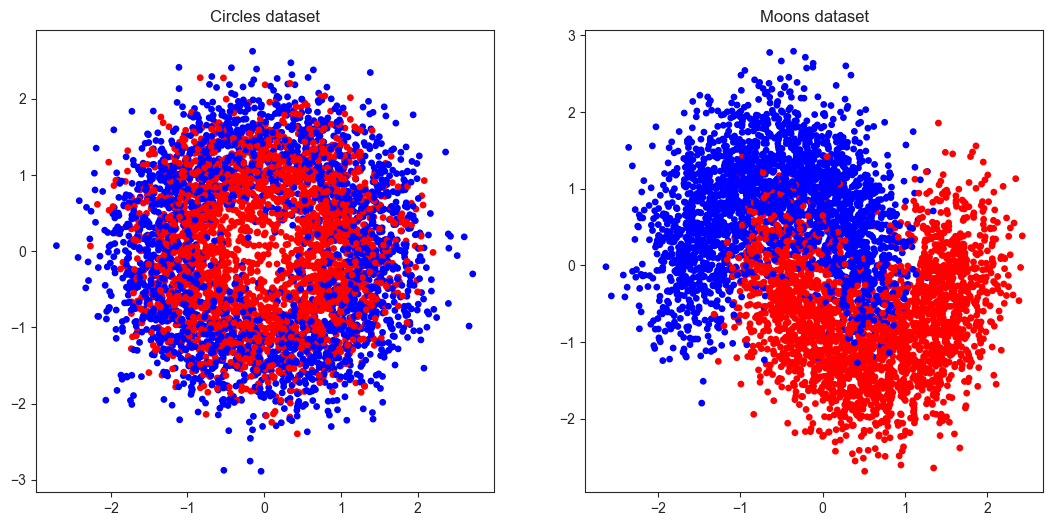

In [64]:
fig, axes = plt.subplots(1, 2, figsize=(13, 6))

axes[0].scatter(X_circles[:, 0], X_circles[:, 1], c=y_circles, cmap='bwr', s=15)
axes[0].set_title("Circles dataset")

axes[1].scatter(X_moons[:, 0], X_moons[:, 1], c=y_moons, cmap='bwr', s=15)
axes[1].set_title("Moons dataset")

plt.show()


### MLP baseline (классическая нейросеть)

In [65]:
mlp = MLPClassifier(
    hidden_layer_sizes=(8,),
    activation="relu",
    solver="adam",
    max_iter=2000,
    random_state=42
)

In [67]:
mlp_acc_circles = evaluate_mlp(mlp, X_circles_train, y_circles_train, X_circles_test, y_circles_test)
mlp_acc_moons = evaluate_mlp(mlp, X_moons_train, y_moons_train, X_moons_test, y_moons_test)

mlp_roc_auc_circles = roc_auc_score(y_circles_test, mlp.predict_proba(X_circles_test)[:, 1])

results.append({
    "Model": "MLP",
    "Dataset": "Circles",
    "n_qubits": None,          
    "Accuracy": mlp_acc_circles,
    "ROC_AUC": mlp_roc_auc_circles
})

mlp_roc_auc_moons = roc_auc_score(y_moons_test, mlp.predict_proba(X_moons_test)[:, 1])

results.append({
    "Model": "MLP",
    "Dataset": "Moons",
    "n_qubits": None,
    "Accuracy": mlp_acc_moons,
    "ROC_AUC": mlp_roc_auc_moons
})

mlp_acc_circles, mlp_acc_moons

(0.6473333333333333, 0.9146666666666666)

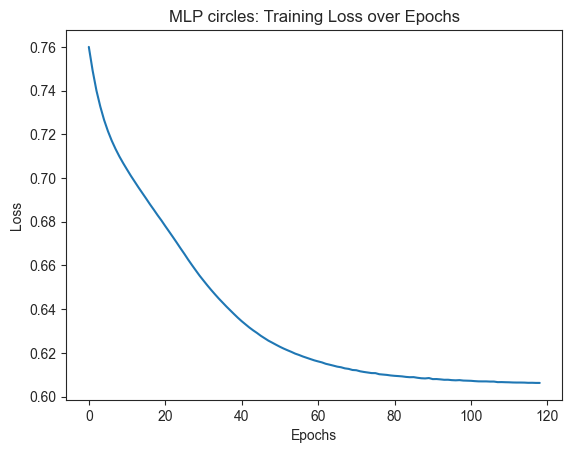

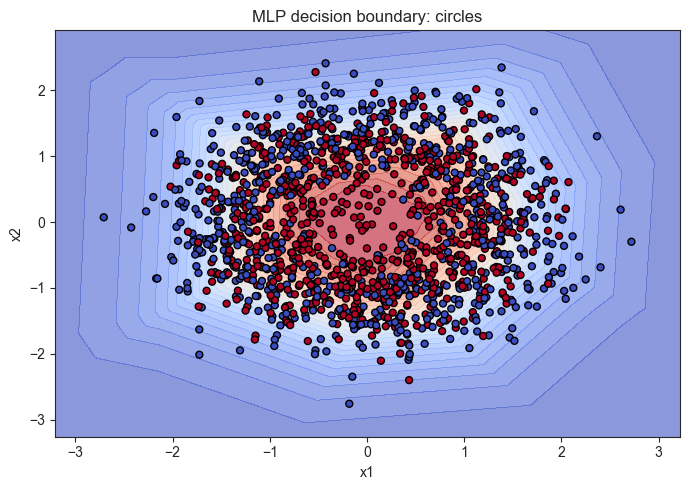

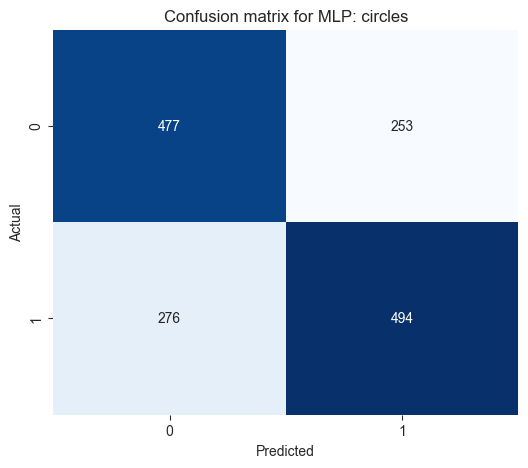

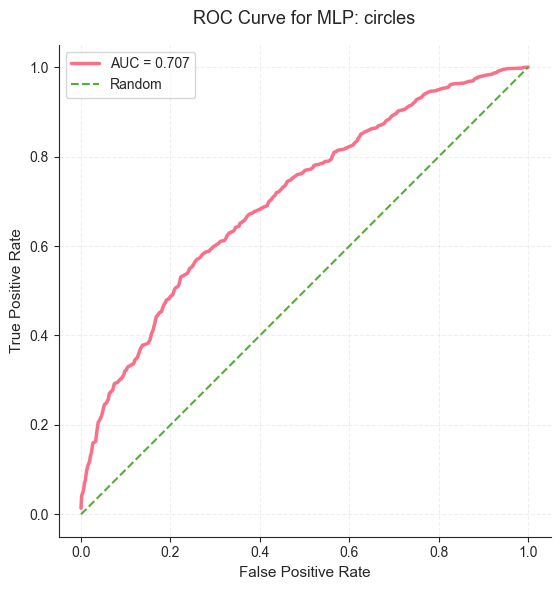

0.7073154243017257

In [68]:
mlp.fit(X_circles_train, y_circles_train)


plt.plot(mlp.loss_curve_)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('MLP circles: Training Loss over Epochs')
plt.show()

plot_decision_boundary(
    mlp,
    X_circles_test,
    y_circles_test,
    title="MLP decision boundary: circles"
)


plot_confusion_matrix(mlp, X_circles_test, y_circles_test, title='Confusion matrix for MLP: circles')

plot_roc_curve_elegant(mlp, X_circles_test, y_circles_test, title='ROC Curve for MLP: circles')

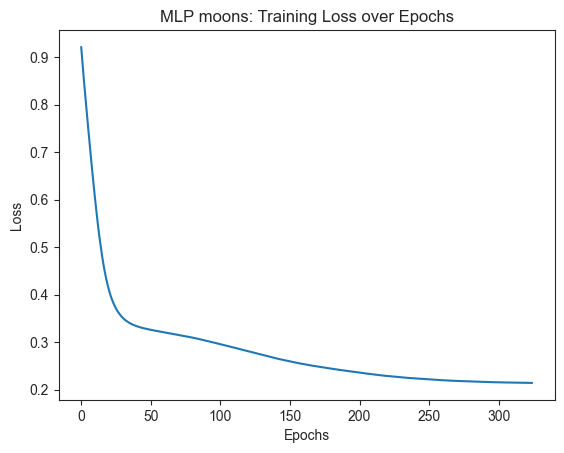

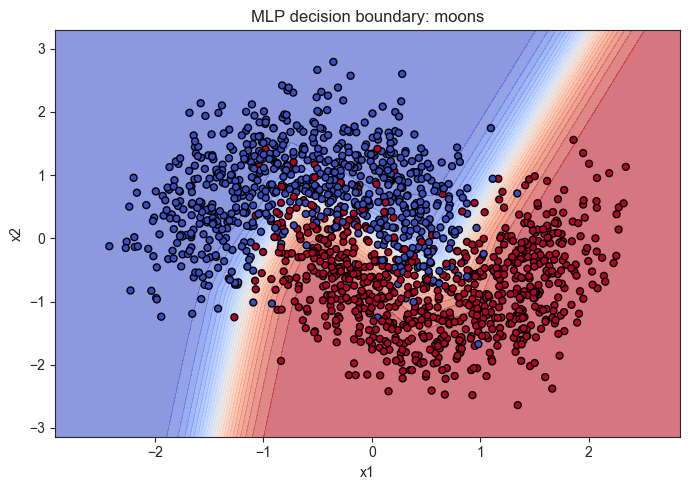

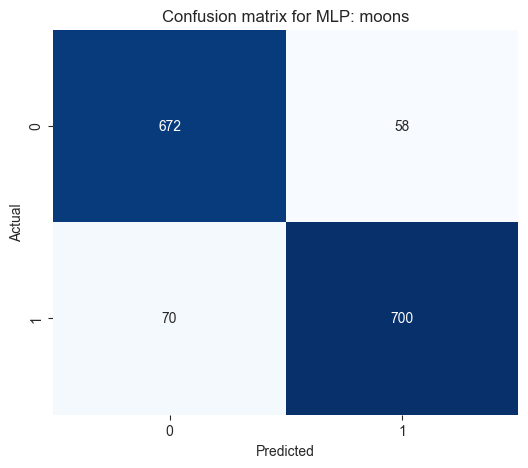

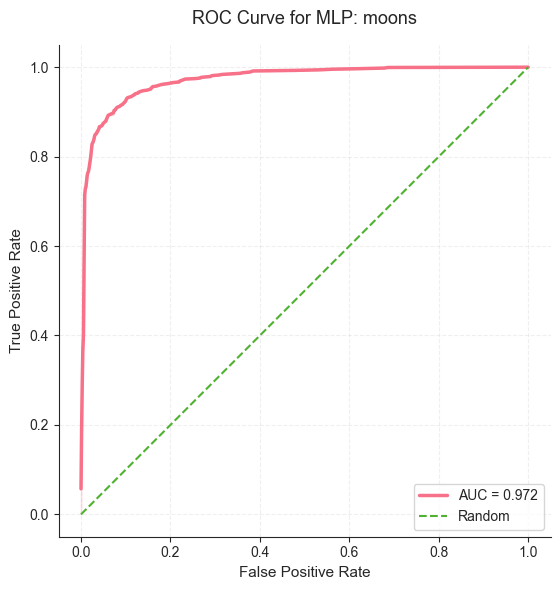

0.9720281088774241

In [53]:
mlp.fit(X_moons_train, y_moons_train)

plt.plot(mlp.loss_curve_)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('MLP moons: Training Loss over Epochs')
plt.show()


plot_decision_boundary(
    mlp,
    X_moons_test,
    y_moons_test,
    title="MLP decision boundary: moons"
)

plot_confusion_matrix(mlp, X_moons_test, y_moons_test, title='Confusion matrix for MLP: moons')

plot_roc_curve_elegant(mlp, X_moons_test, y_moons_test, title='ROC Curve for MLP: moons')

### Суть вариационной квантовой схемы (VQC)

**Variational Quantum Classifier (VQC)** — это квантово-классическая модель машинного обучения, в которой классификация осуществляется с помощью параметризованной квантовой схемы, оптимизируемой градиентными методами.

В общем виде модель можно представить как отображение

$$
x \xrightarrow{\text{embedding}} |\psi(x)\rangle
:\xrightarrow{\text{parametrized circuit}}
:\xrightarrow{\text{measurement}}
\hat{y}
$$

где:

* $x \in \mathbb{R}^d$ — входной вектор признаков,
* $|\psi(x)\rangle$ — квантовое состояние, кодирующее входные данные,
* $\hat{y}$ — предсказание модели.



#### Что происходит математически

**1. Кодирование данных (AngleEmbedding)**
```
Классические данные (x₁, x₂) → Квантовое состояние
```
Каждое число становится углом вращения кубита:
$$|ψ\rangle = R_Y(x_1)|0\rangle_1 \otimes R_Y(x_2)|0\rangle_2$$

**2. Вариационные слои (StronglyEntanglingLayers)**

Для каждого слоя:
- **Вращения**: 3 угла (θ₁, θ₂, θ₃) поворачивают каждый кубит произвольным образом
- **CNOT**: запутывает кубиты → они начинают "влиять друг на друга"

Итого: 2 слоя × 2 кубита × 3 угла = **12 обучаемых параметров**

**3. Измерение**
```
Квантовое состояние → Число в [-1, 1]
```
$$\langle Z_0 \rangle = P(\text{кубит в }|0\rangle) - P(\text{кубит в }|1\rangle)$$

**4. Sigmoid**
```
[-1, 1] → [0, 1] (вероятность класса)
```

#### Физический смысл

- **Вращения** = настраиваемые фильтры для признаков
- **Запутывание** = нелинейное взаимодействие между признаками (как скрытые слои в нейросети)
- **Измерение** = проекция результата в классическое число

#### Почему это "квантовое"?

Квантовое запутывание позволяет 2 кубитам исследовать **4-мерное** пространство состояний одновременно, а не по очереди. Для n кубитов — это $2^n$ измерений, что дает потенциальное преимущество.

#### Обучение

Градиенты вычисляются квантовым способом:
$$\frac{\partial f}{\partial θ} = \frac{f(θ + π/2) - f(θ - π/2)}{2}$$

Запускаем схему с чуть разными углами, сравниваем результаты — получаем направление для оптимизации.

---

**Вся схема**: данные -> квантовое кодирование -> параметризованные унитарные преобразования с запутыванием -> измерение -> классическая функция активации -> предсказание

In [24]:
import pennylane as qml
import torch
import torch.nn as nn

class VQC(nn.Module):
    def __init__(self, n_qubits=2, dev_name="default.qubit"):
        super(VQC, self).__init__()
        self.n_qubits = n_qubits
        self.dev = qml.device(dev_name, wires=self.n_qubits)

        # Квантовая схема
        @qml.qnode(self.dev, interface="torch")
        def quantum_circuit(inputs, weights):
            qml.AngleEmbedding(inputs, wires=range(self.n_qubits)) # Embedding (кодирование признаков): каждый признак -> угол вращения
            qml.StronglyEntanglingLayers(weights, wires=range(self.n_qubits)) # Ansatz (вариационная схема): аналог скрытых слоев нейросети
            return qml.expval(qml.PauliZ(0))

        weight_shapes = {"weights": (2, self.n_qubits, 3)}
        self.quantum_layer = qml.qnn.TorchLayer(quantum_circuit, weight_shapes) # Оборачивание в PyTorch слой

        self.model = nn.Sequential(
            self.quantum_layer,
            nn.Sigmoid() # Вероятность класса
        )

    def forward(self, x):
        return self.model(x).squeeze()

    def fit(self, X_train, y_train, epochs=150):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=0.1)
        loss_fn = torch.nn.BCELoss()

        X_train_t = torch.tensor(X_train, dtype=torch.float32)
        y_train_t = torch.tensor(y_train, dtype=torch.float32)

        self.model.train()
        losses = []
        for _ in range(epochs):
            optimizer.zero_grad()
            preds = self.model(X_train_t).squeeze()
            loss = loss_fn(preds, y_train_t)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        return losses

    def predict(self, X_test):
        self.model.eval()
        with torch.no_grad():
            preds = self.model(torch.tensor(X_test, dtype=torch.float32)).squeeze()
            y_pred = (preds > 0.5).int().numpy()

        return y_pred
    
    def score(self, X_test, y_test):
        y_pred = self.predict(X_test)
        return (y_pred == y_test).mean()

**VQC with circles dataset**

Accuracy: 0.5946666666666667


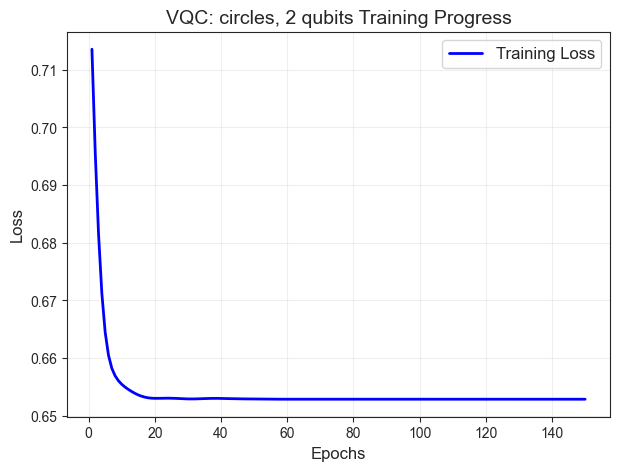

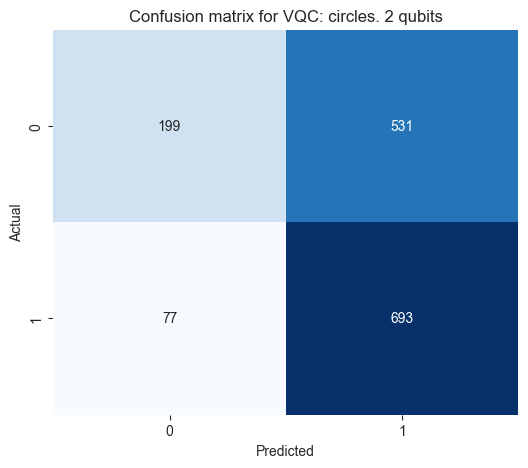

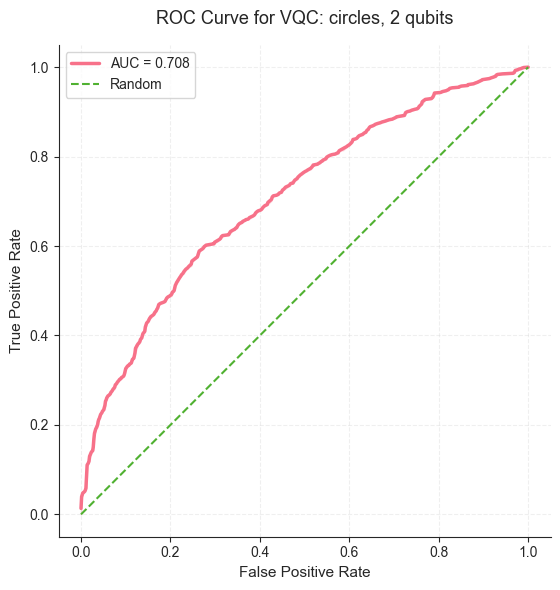

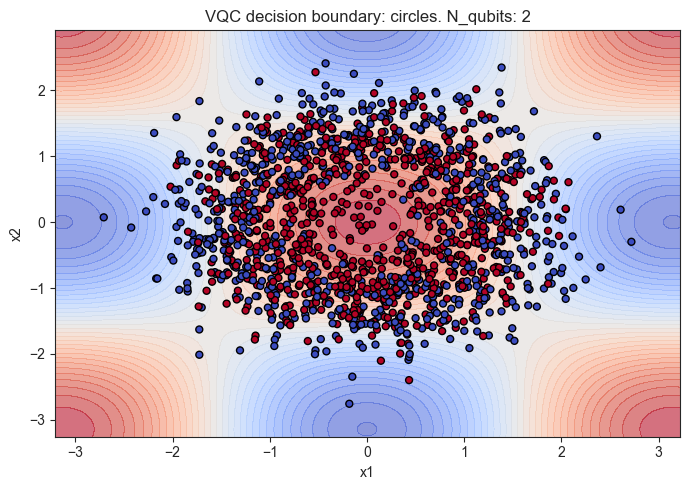

Accuracy: 0.5933333333333334


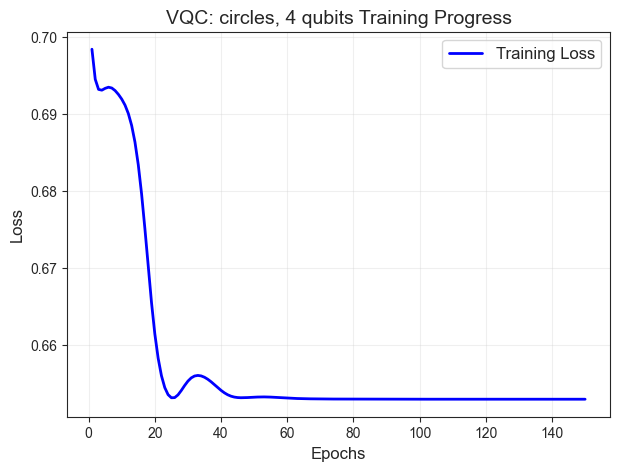

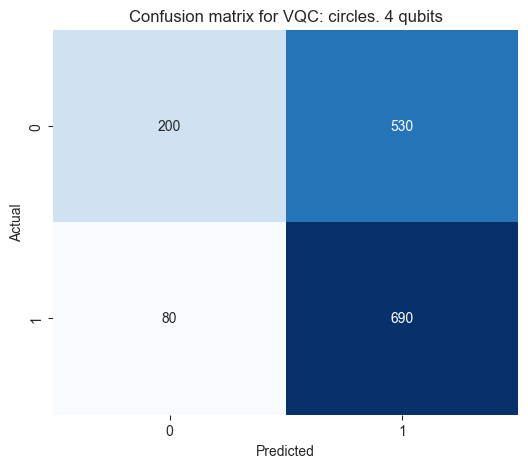

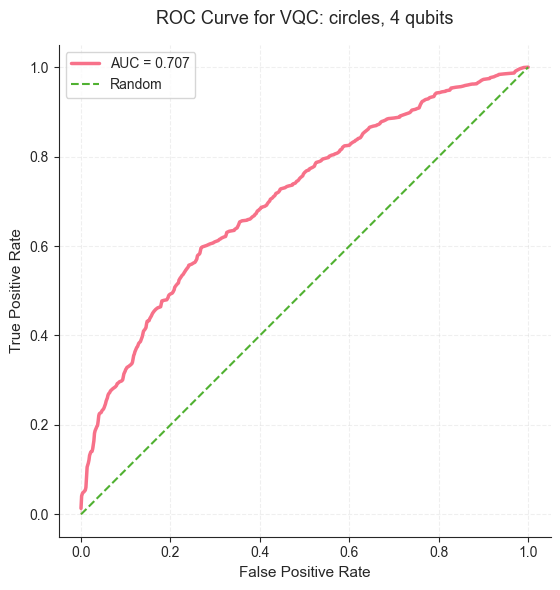

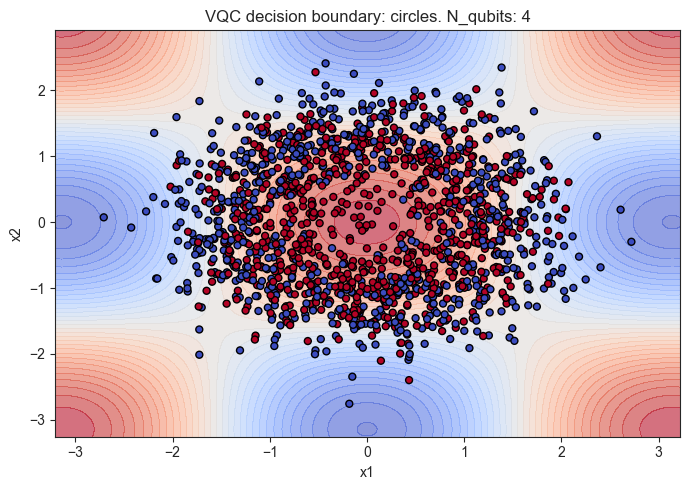

Accuracy: 0.634


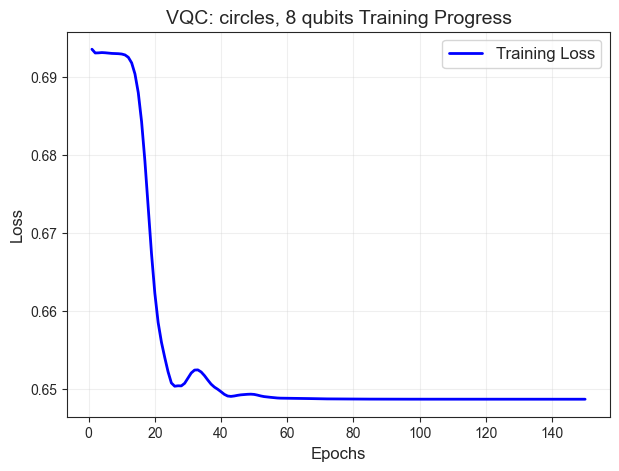

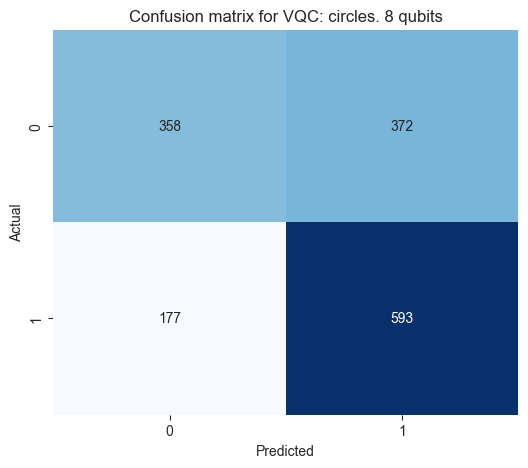

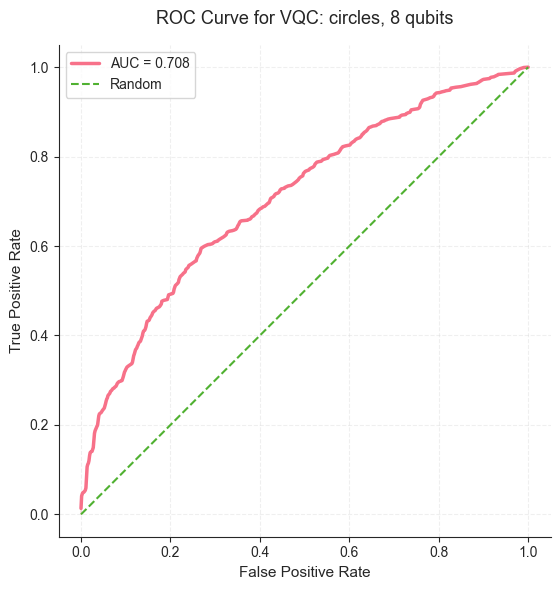

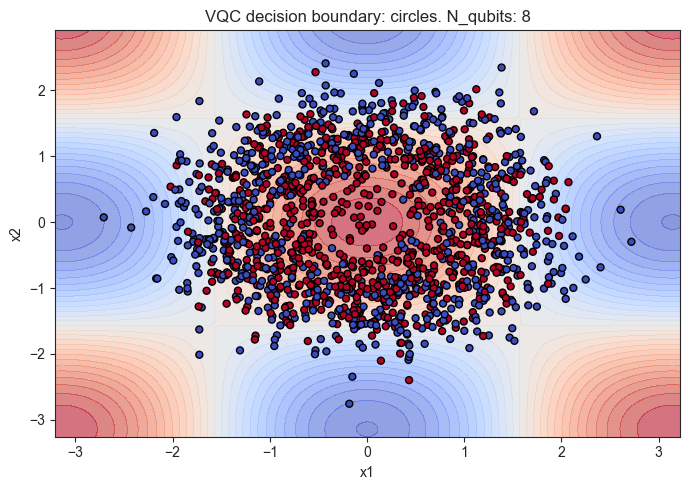

In [45]:
qubits = [2, 4, 8]
for n_qubits in qubits:
    vqc_circles = VQC(n_qubits=n_qubits)
    losses = vqc_circles.fit(X_circles_train, y_circles_train)
    y_pred_circles = vqc_circles.predict(X_circles_test)

    vqc_score_circles = vqc_circles.score(X_circles_test, y_circles_test)


    results.append({
        "Model": "VQC",
        "Dataset": "Circles",
        "n_qubits": n_qubits,
        "Accuracy": vqc_score_circles
    })

    print(f"Accuracy: {vqc_score_circles}")

    training_plot(losses, f'VQC: circles, {n_qubits} qubits Training Progress')

    plot_confusion_matrix(vqc_circles, X_circles_test, y_circles_test, title=f'Confusion matrix for VQC: circles. {n_qubits} qubits')

    plot_roc_curve_elegant(vqc_circles, X_circles_test, y_circles_test, title=f'ROC Curve for VQC: circles, {n_qubits} qubits')

    plot_decision_boundary(
        vqc_circles,
        X_circles_test,
        y_circles_test,
        title=f"VQC decision boundary: circles. N_qubits: {n_qubits}",
        is_torch=True
    )

**VQC with moons dataset**

Accuracy: 0.52


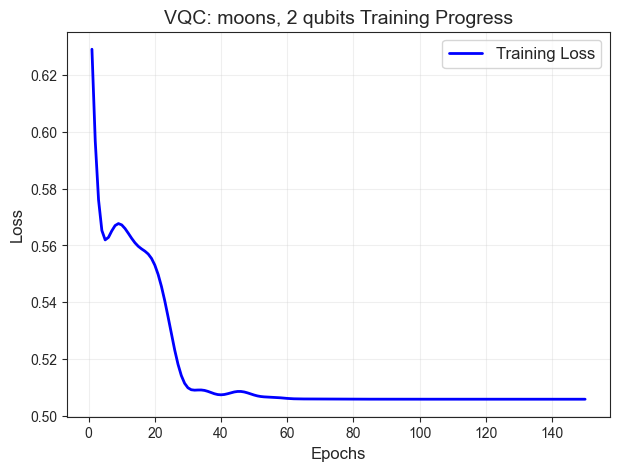

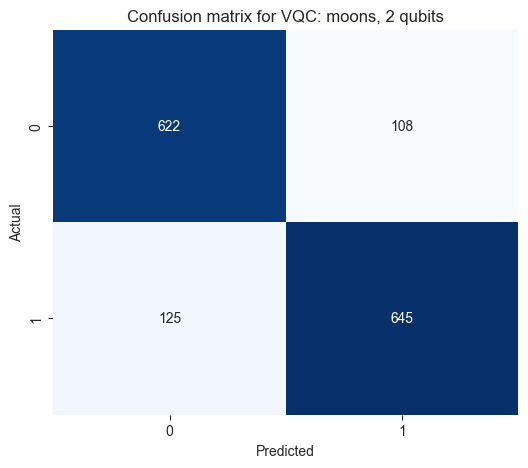

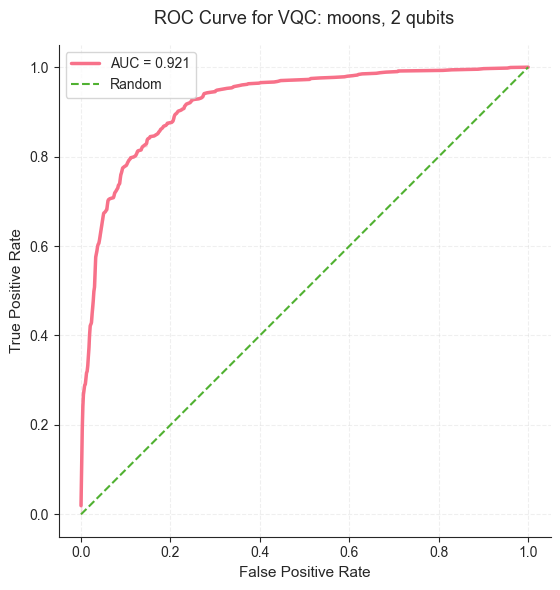

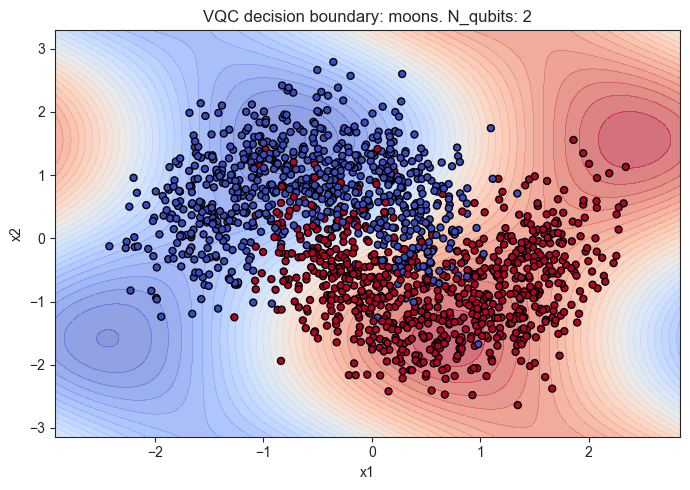

Accuracy: 0.528


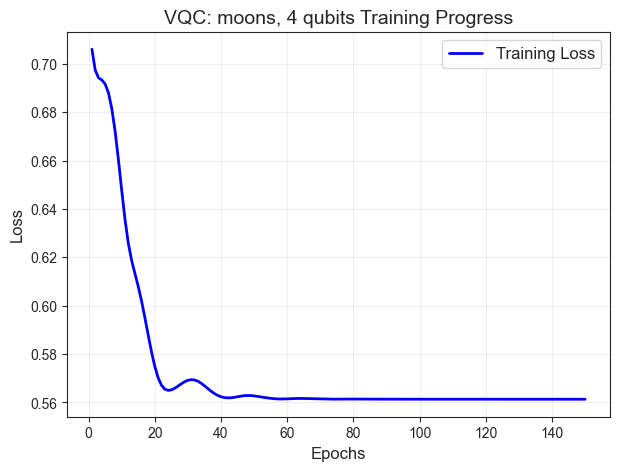

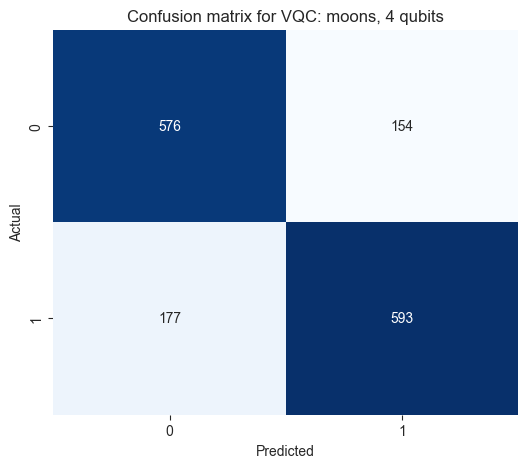

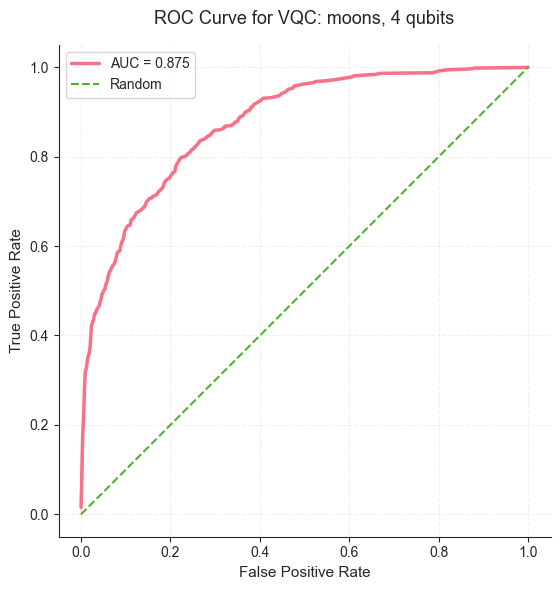

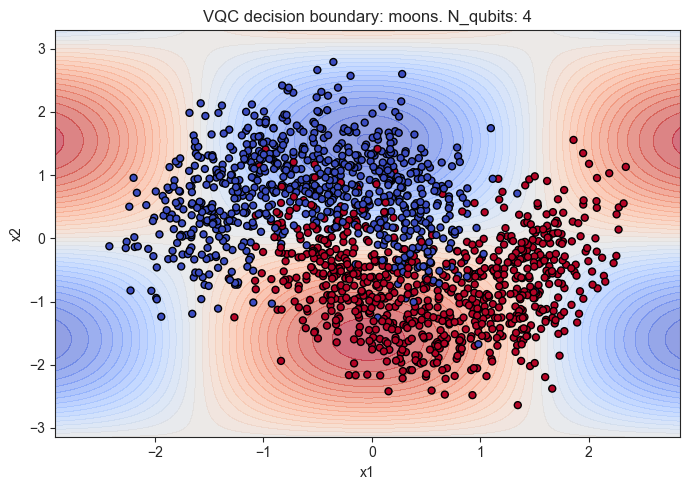

Accuracy: 0.5286666666666666


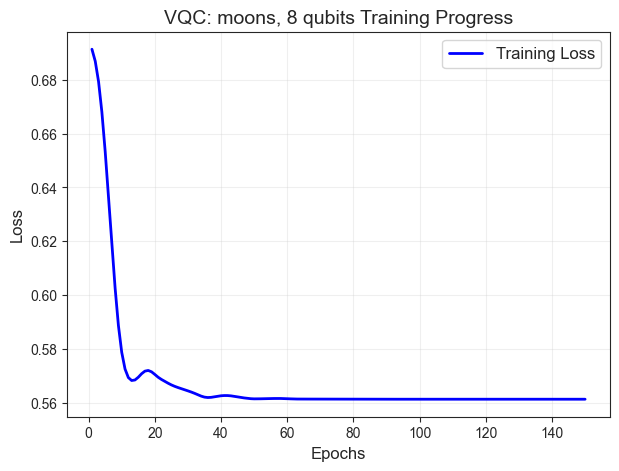

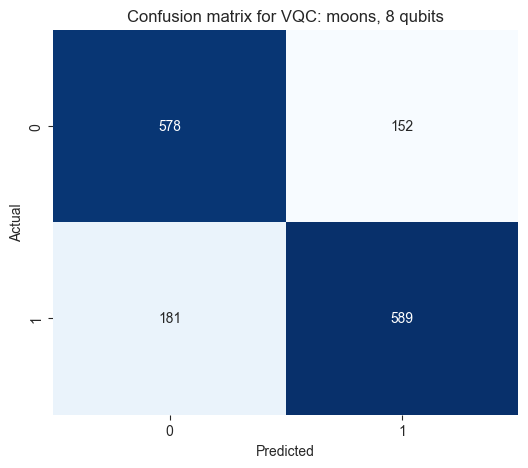

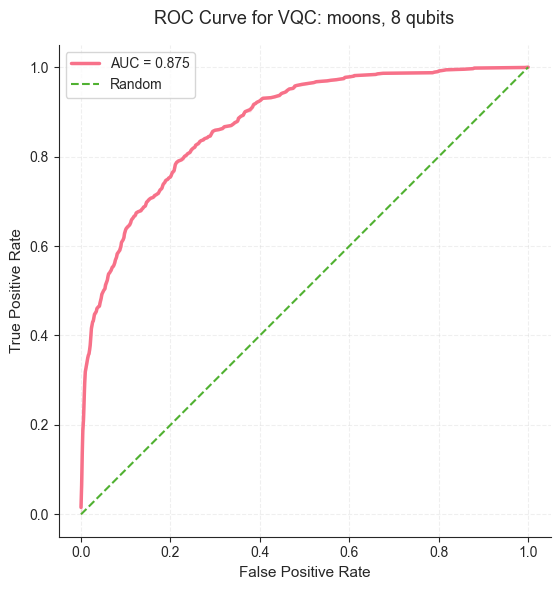

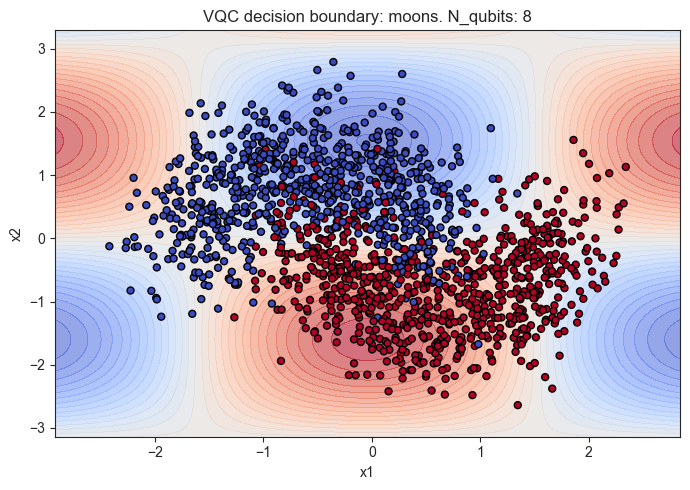

In [ ]:
qubits = [2, 4, 8]
for n_qubits in qubits:
    vqc_moons = VQC(n_qubits=n_qubits)
    losses = vqc_moons.fit(X_moons_train, y_moons_train)
    y_pred_moons = vqc_moons.predict(X_moons_test)

    vqc_score_moons = vqc_moons.score(X_circles_test, y_moons_test)

    results.append({
        "Model": "VQC",
        "Dataset": "Moons",
        "n_qubits": n_qubits,
        "Accuracy": vqc_score_moons
    })

    print(f"Accuracy: {vqc_score_moons}")
    
    training_plot(losses, f'VQC: moons, {n_qubits} qubits Training Progress')

    plot_confusion_matrix(vqc_moons, X_moons_test, y_moons_test, title=f'Confusion matrix for VQC: moons, {n_qubits} qubits')

    plot_roc_curve_elegant(vqc_moons, X_moons_test, y_moons_test, title=f'ROC Curve for VQC: moons, {n_qubits} qubits')

    plot_decision_boundary(
        vqc_moons,
        X_moons_test,
        y_moons_test,
        title=f"VQC decision boundary: moons. N_qubits: {n_qubits}",
        is_torch=True
    )


### VQC - как нелинейный преобразователь признаков



#### Общая структура

Модель — это композиция квантового и классического преобразований:

$$f(\mathbf{x}) = \sigma\left(\mathbf{w}^T Q(\mathbf{x}, \boldsymbol{\theta}) + b\right)$$

- $Q: \mathbb{R}^2 \to \mathbb{R}^2$ — квантовое отображение (извлечение признаков)
- Линейный слой: $\mathbb{R}^2 \to \mathbb{R}$ — классификация
- Sigmoid: $\mathbb{R} \to [0,1]$ — вероятность

#### Квантовая часть

##### 1. Кодирование данных
$$|\psi_0\rangle = R_Y(x_1)|0\rangle \otimes R_Y(x_2)|0\rangle$$

Данные $(x_1, x_2)$ становятся углами вращения кубитов.

##### 2. Вариационные слои (3 слоя)

Каждый слой: **вращения** → **запутывание**

$$U_\ell = E_\ell \cdot \prod_{i=1}^{2} R_Z(\theta_3^i)R_Y(\theta_2^i)R_Z(\theta_1^i)$$

где $E_\ell$ — CNOT-гейты между кубитами.

**Параметры**: 3 слоя × 2 кубита × 3 угла = **18 квантовых параметров**

##### 3. Измерение обоих кубитов

$$Q_i = \langle\psi| Z_i |\psi\rangle = P(|0\rangle_i) - P(|1\rangle_i) \in [-1,1]$$

Получаем вектор:
$$\mathbf{Q} = (Q_0, Q_1)^T \in [-1,1]^2$$

#### Классическая часть

Линейная комбинация квантовых признаков:

$$z = w_0 Q_0 + w_1 Q_1 + b$$

**Параметры**: 2 веса + 1 bias = **3 классических параметра**

Затем sigmoid: $\hat{y} = \frac{1}{1+e^{-z}}$

#### Обучение

##### Функция потерь
$$\mathcal{L} = -\frac{1}{N}\sum_{i=1}^N \left[y_i \log(\hat{y}_i) + (1-y_i)\log(1-\hat{y}_i)\right]$$

##### Градиенты

**Квантовые** (правило сдвига параметра):
$$\frac{\partial Q_i}{\partial \theta_j} = \frac{Q_i(\theta_j + \pi/2) - Q_i(\theta_j - \pi/2)}{2}$$

**Классические** (обычный backprop):
$$\frac{\partial \mathcal{L}}{\partial w_i} = \frac{\partial \mathcal{L}}{\partial z} \cdot Q_i$$

#### Физический смысл

**Запутывание** создает корреляции между кубитами:
$$\langle Z_0 Z_1 \rangle \neq \langle Z_0 \rangle \langle Z_1 \rangle$$

Это означает, что $Q_0$ и $Q_1$ **нелинейно зависят** от обоих входов $(x_1, x_2)$, а не только от "своего" входа.

**Гибридность**: 
- Квантовая схема через запутывание строит нелинейное представление данных
- Классический слой находит оптимальную границу в пространстве $(Q_0, Q_1)$


```
Вход -> Квантовое кодирование -> 3 слоя (вращения + запутывание) -> 
-> Измерение 2 кубитов -> Линейная комбинация -> Sigmoid -> Предсказание
```

Архитектура аналогична двухслойной нейросети, где квантовая часть - это нелинейный скрытый слой

In [33]:
import pennylane as qml
import torch
import torch.nn as nn

class VQC_hybrid(nn.Module):
    def __init__(self, n_qubits=2, n_layers=3, dev_name='default.qubit'):
        super(VQC_hybrid, self).__init__()
        self.n_qubits = n_qubits
        self.n_layers = n_layers

        self.dev = qml.device(dev_name, wires=n_qubits)

        @qml.qnode(self.dev, interface="torch")
        def quantum_circuit(inputs, weights):
            qml.AngleEmbedding(inputs, wires=range(self.n_qubits)) # Embedding (кодирование признаков): каждый признак -> угол вращения
            qml.StronglyEntanglingLayers(weights, wires=range(self.n_qubits)) # Ansatz (вариационная схема)
            return [qml.expval(qml.PauliZ(i)) for i in range(self.n_qubits)]

        weight_shapes = {"weights": (self.n_layers, self.n_qubits, 3)}
        self.quantum_layer = qml.qnn.TorchLayer(quantum_circuit, weight_shapes)

        # Гибрид: квантовый слой + классический линейный слой
        self.model = nn.Sequential(
            self.quantum_layer,
            nn.Linear(n_qubits, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x).squeeze()

    def fit(self, X_train, y_train, epochs=150):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=0.1)
        loss_fn = torch.nn.BCELoss()

        X_train_t = torch.tensor(X_train, dtype=torch.float32)
        y_train_t = torch.tensor(y_train, dtype=torch.float32)

        self.model.train()
        losses = []
        for _ in range(epochs):
            optimizer.zero_grad()
            preds = self.model(X_train_t).squeeze()
            loss = loss_fn(preds, y_train_t)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        return losses
    

    def predict(self, X_test):
        self.model.eval()
        with torch.no_grad():
            preds = self.model(torch.tensor(X_test, dtype=torch.float32)).squeeze()
            y_pred = (preds > 0.5).int().numpy()

        return y_pred
    
    def score(self, X_test, y_test):
        y_pred = self.predict(X_test)
        return (y_pred == y_test).mean()

**VQC_hybrid with circles dataset**

Accuracy: 0.6553333333333333


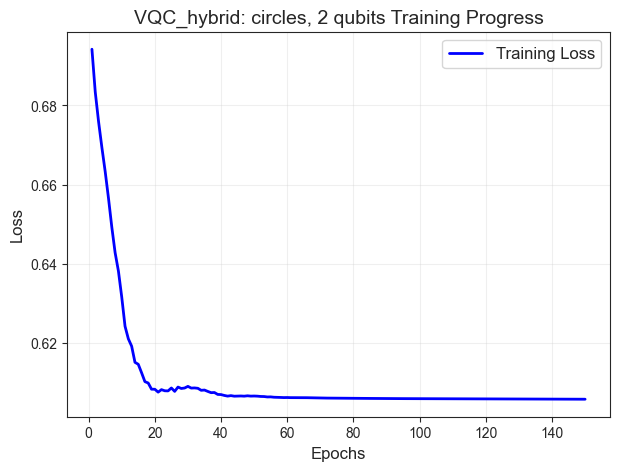

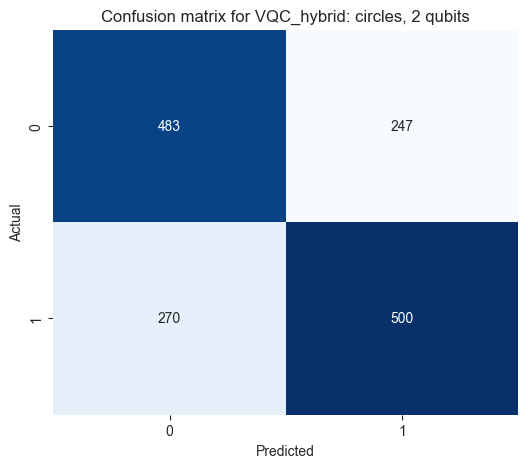

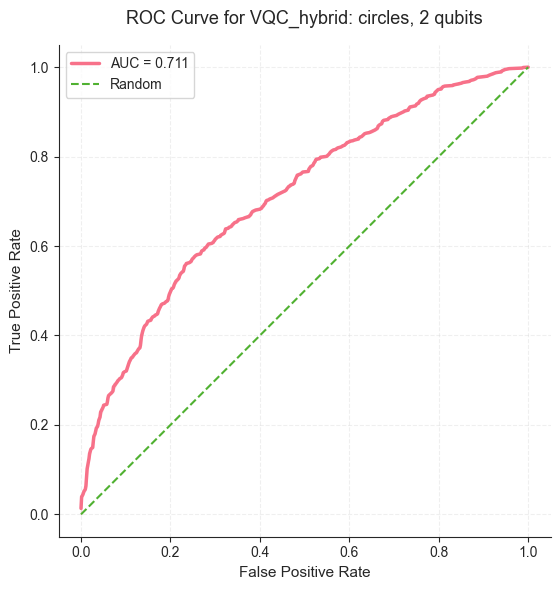

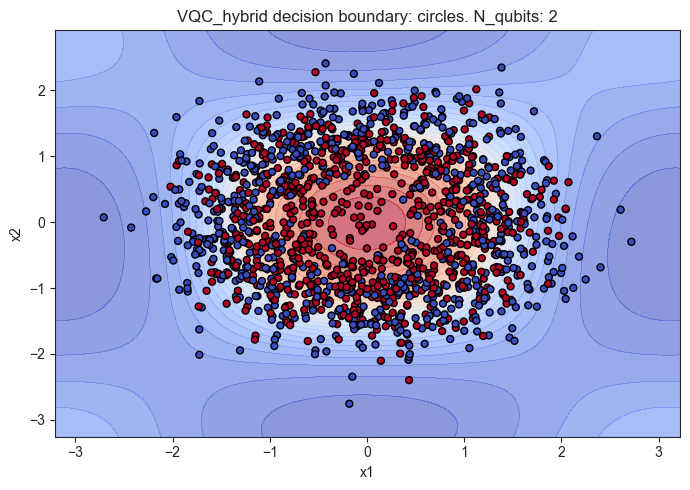

Accuracy: 0.6546666666666666


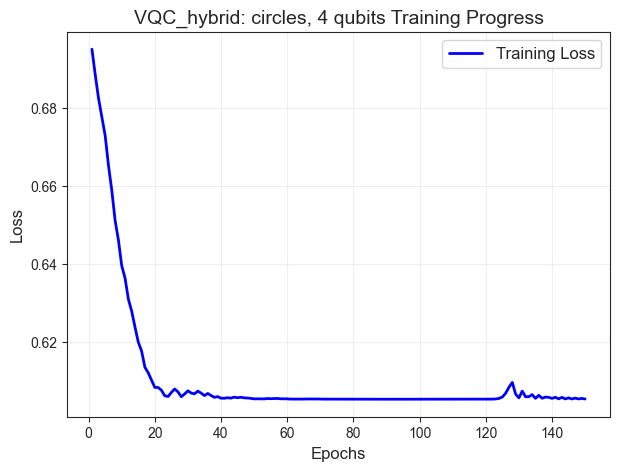

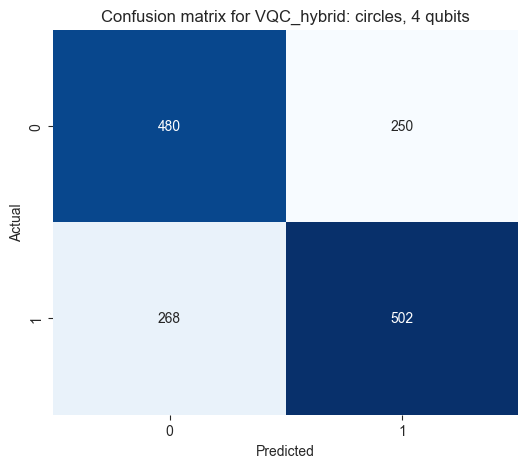

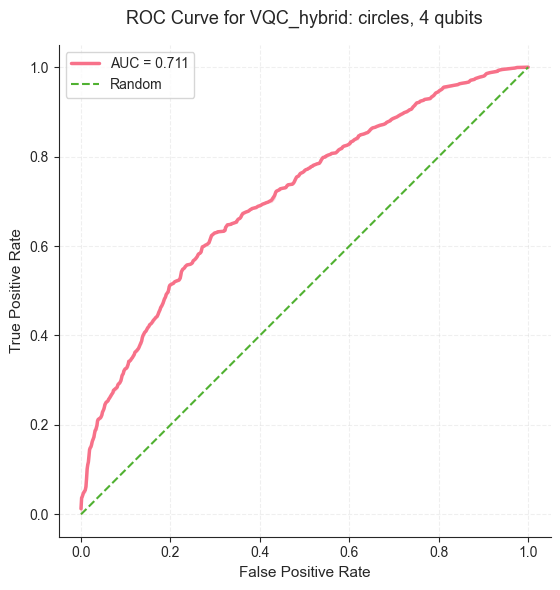

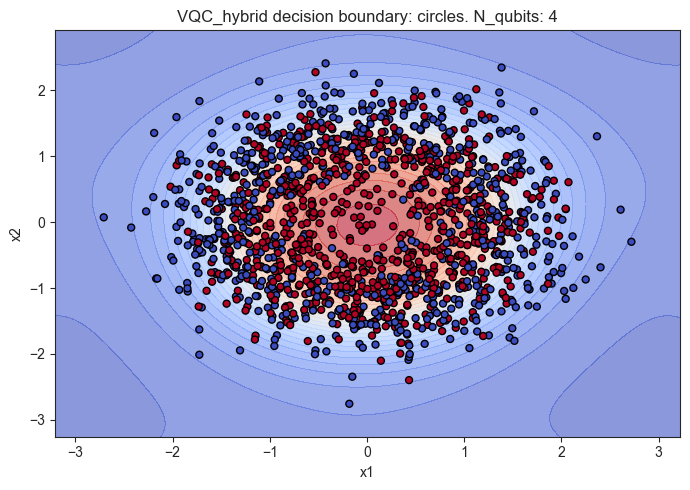

Accuracy: 0.6533333333333333


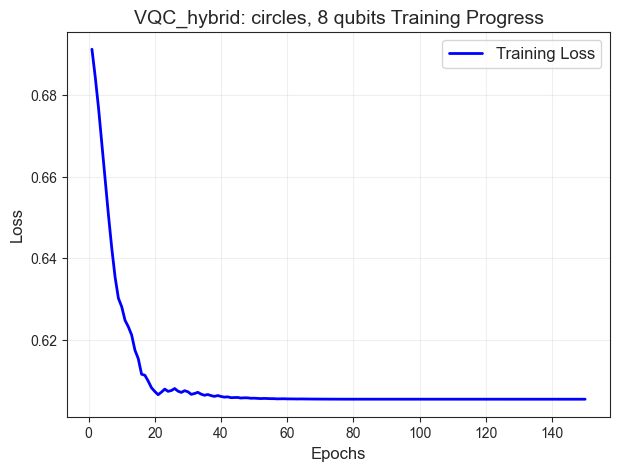

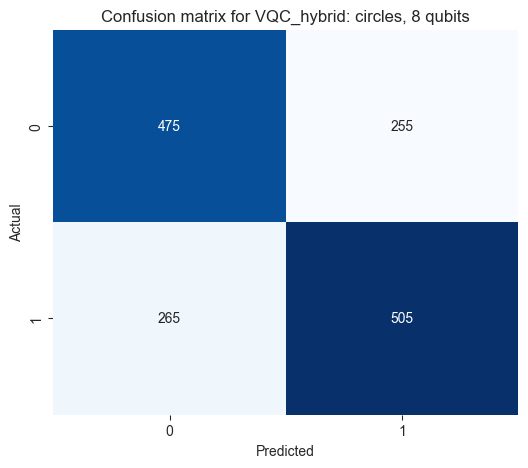

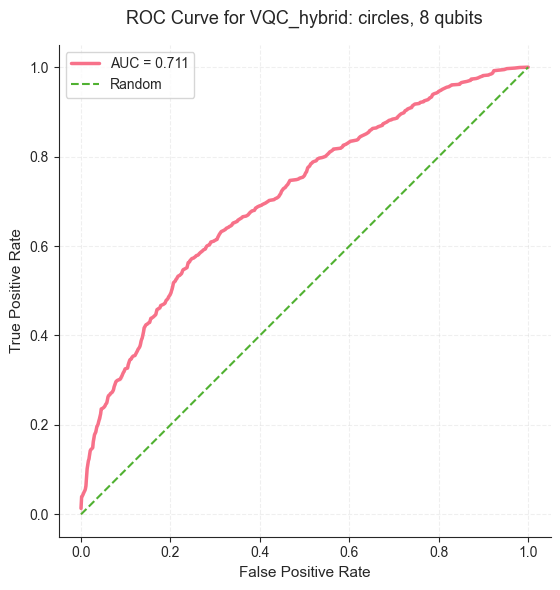

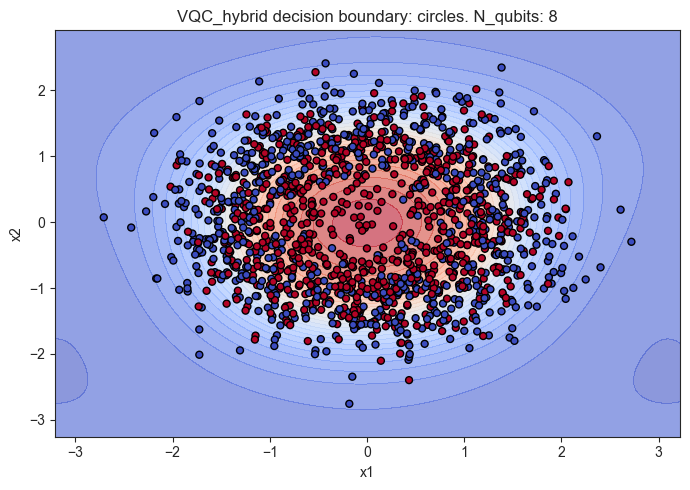

In [47]:
qubits = [2, 4, 8]
for n_qubits in qubits:
    vqc_hybrid_circles = VQC_hybrid(n_qubits=n_qubits)

    losses = vqc_hybrid_circles.fit(X_circles_train, y_circles_train)
    y_pred_hybrid_circles = vqc_hybrid_circles.predict(X_circles_test)

    vqc_hybrid_score_circles = vqc_hybrid_circles.score(X_circles_test, y_circles_test)


    results.append({
        "Model": "VQC_hybrid",
        "Dataset": "Circles",
        "n_qubits": n_qubits,
        "Accuracy": vqc_hybrid_score_circles
    })


    print(f"Accuracy: {vqc_hybrid_score_circles}")

    training_plot(losses, f'VQC_hybrid: circles, {n_qubits} qubits Training Progress')
    
    plot_confusion_matrix(vqc_hybrid_circles, X_circles_test, y_circles_test, title=f'Confusion matrix for VQC_hybrid: circles, {n_qubits} qubits')

    plot_roc_curve_elegant(vqc_hybrid_circles, X_circles_test, y_circles_test, title=f'ROC Curve for VQC_hybrid: circles, {n_qubits} qubits')
    

    plot_decision_boundary(
        vqc_hybrid_circles,
        X_circles_test,
        y_circles_test,
        title=f"VQC_hybrid decision boundary: circles. N_qubits: {n_qubits}",
        is_torch=True
    )


**VQC_hybrid with moons dataset**

Accuracy: 0.8806666666666667


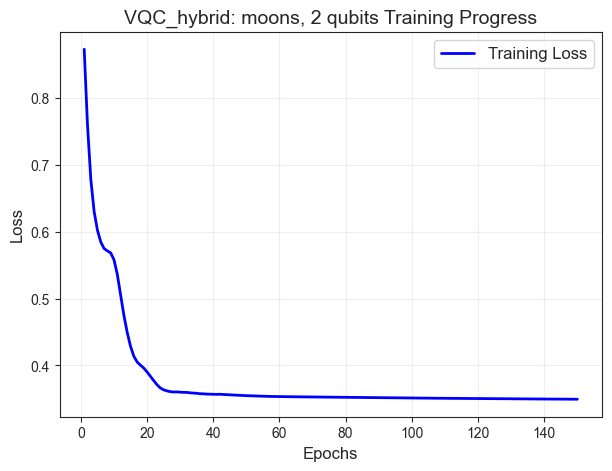

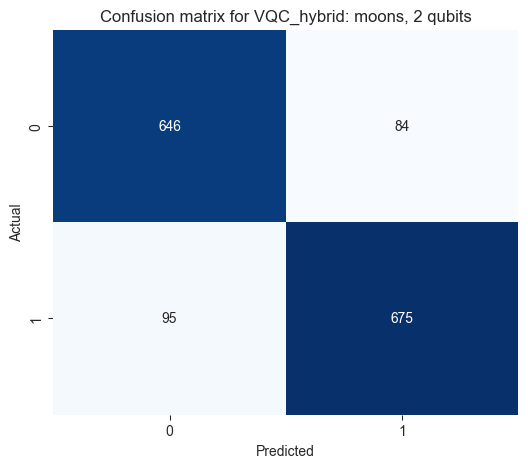

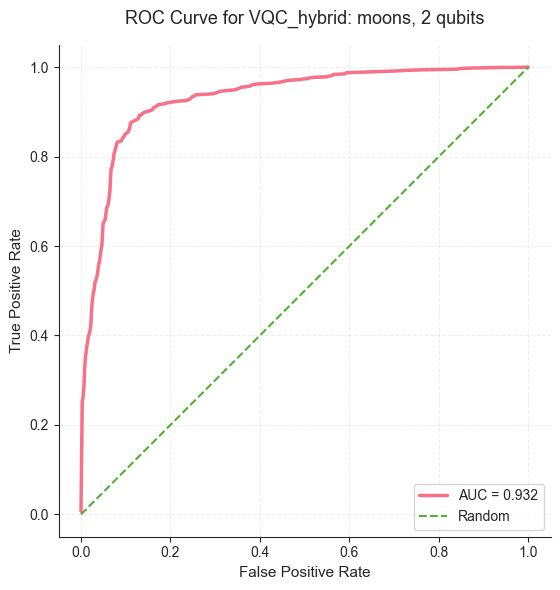

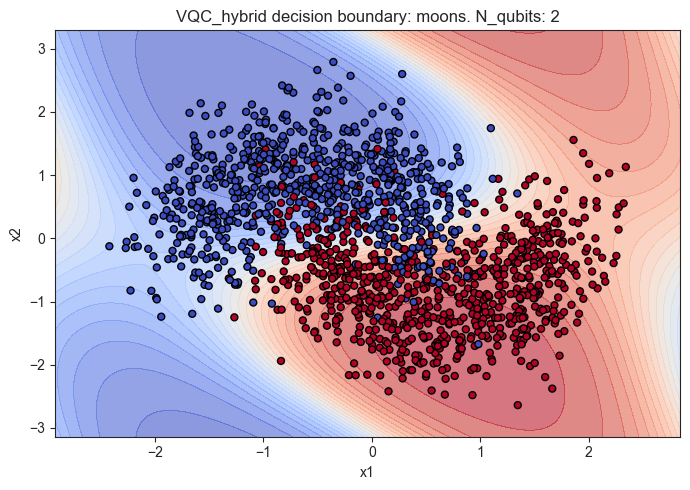

Accuracy: 0.884


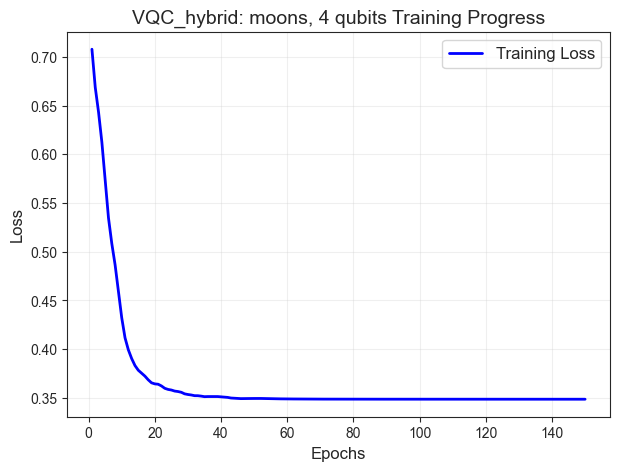

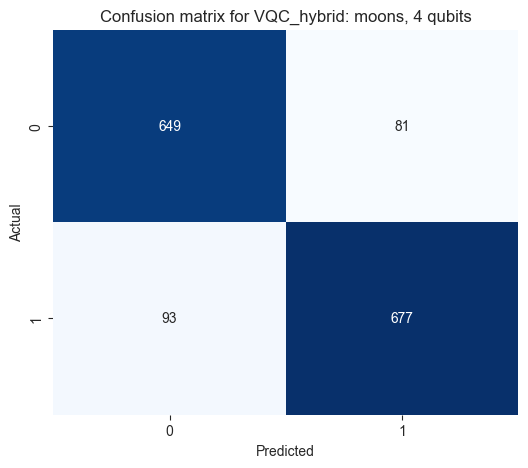

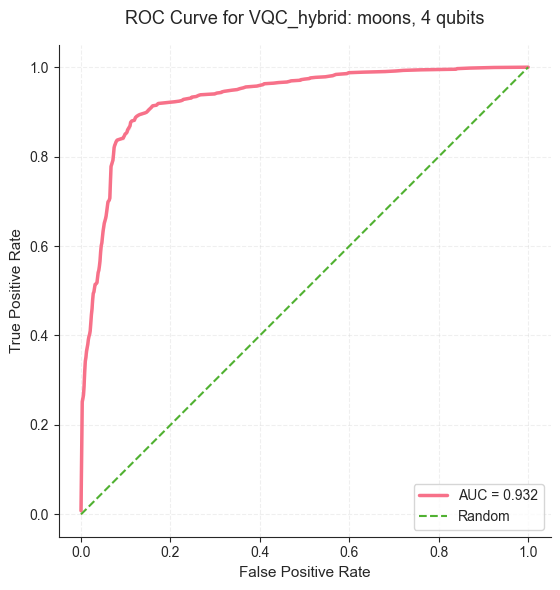

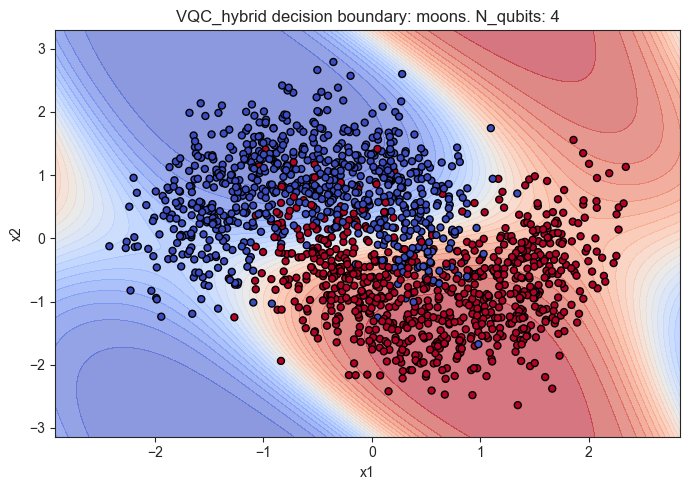

Accuracy: 0.8806666666666667


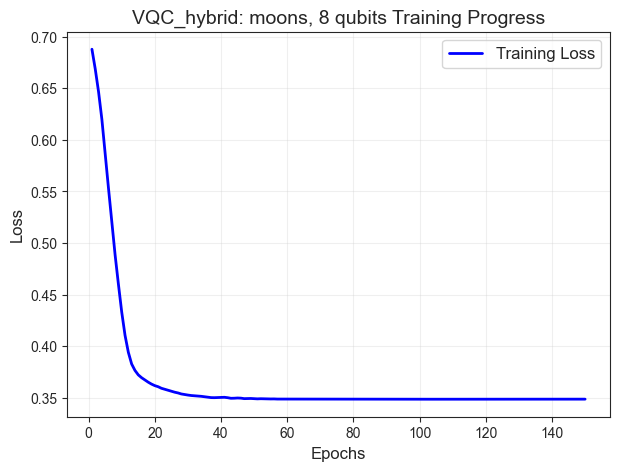

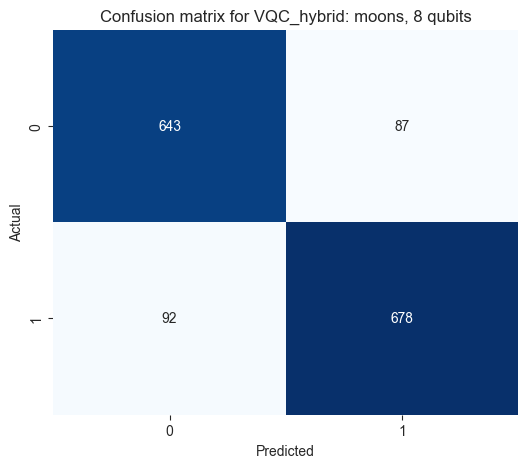

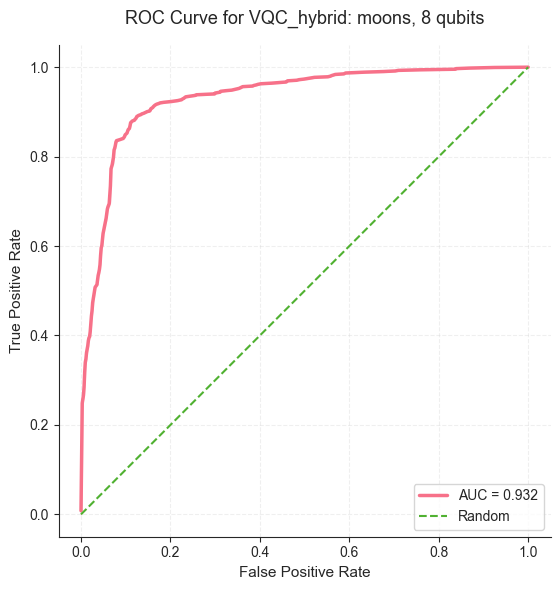

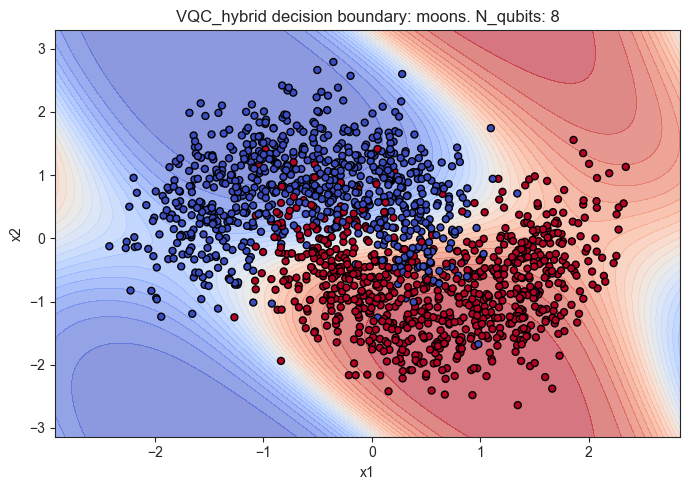

In [48]:
qubits = [2, 4, 8]
for n_qubits in qubits:
    vqc_hybrid_moons = VQC_hybrid(n_qubits=n_qubits)

    losses = vqc_hybrid_moons.fit(X_moons_train, y_moons_train)
    y_pred_hybrid_moons = vqc_hybrid_moons.predict(X_moons_test)

    vqc_hybrid_score_moons = vqc_hybrid_moons.score(X_moons_test, y_moons_test)

    results.append({
        "Model": "VQC_hybrid",
        "Dataset": "Moons",
        "n_qubits": n_qubits,
        "Accuracy": vqc_hybrid_score_moons
    })

    print(f"Accuracy: {vqc_hybrid_score_moons}")

    training_plot(losses, f'VQC_hybrid: moons, {n_qubits} qubits Training Progress')


    plot_confusion_matrix(vqc_hybrid_moons, X_moons_test, y_moons_test, title=f'Confusion matrix for VQC_hybrid: moons, {n_qubits} qubits')

    plot_roc_curve_elegant(vqc_hybrid_moons, X_moons_test, y_moons_test, title=f'ROC Curve for VQC_hybrid: moons, {n_qubits} qubits')
    

    plot_decision_boundary(
        vqc_hybrid_moons,
        X_moons_test,
        y_moons_test,
        title=f"VQC_hybrid decision boundary: moons. N_qubits: {n_qubits}",
        is_torch=True
    )


### Результаты

In [205]:
df_results = pd.DataFrame(results)

df_results = df_results.sort_values(
    by=["Dataset", "Accuracy"],
    ascending=[True, False]
)

df_results

Model  Dataset  n_qubits  Accuracy
10  VQC_hybrid  Circles       8.0  0.656000
9   VQC_hybrid  Circles       4.0  0.654000
8   VQC_hybrid  Circles       2.0  0.652667
0          MLP  Circles       NaN  0.647333
4          VQC  Circles       8.0  0.634667
3          VQC  Circles       4.0  0.634000
2          VQC  Circles       2.0  0.593333
1          MLP    Moons       NaN  0.914667
11  VQC_hybrid    Moons       2.0  0.884000
12  VQC_hybrid    Moons       4.0  0.884000
13  VQC_hybrid    Moons       8.0  0.882667
6          VQC    Moons       4.0  0.528667
7          VQC    Moons       8.0  0.528667
5          VQC    Moons       2.0  0.520000

## Вывод

На синтетических датасетах Circles и Moons проведено сравнение трёх моделей: классического MLP, чистого VQC и гибридного VQC_hybrid. Результаты показали, что MLP стабильно демонстрирует высокую точность классификации на обеих задачах, чистый VQC уступает обеим моделям, особенно на Moons, где точность близка к случайной (≈0.5). Гибридная модель VQC_hybrid почти догоняет MLP, особенно на Circles, что подтверждает эффективность квантового слоя в качестве обучаемого нелинейного feature extractor.

Дополнительно наблюдается **влияние числа кубитов (n_qubits) на точность моделей**:

* Для VQC_hybrid увеличение числа кубитов с 2 до 8 даёт **небольшой рост точности на Circles**, но на Moons результат стабилен и даже слегка падает.
* Для чистого VQC рост числа кубитов улучшает точность на Circles, но на Moons улучшение минимальное, оставаясь близким к случайной классификации.

Это подчёркивает, что **увеличение числа кубитов расширяет пространство признаков и потенциал квантовой схемы**, однако для сложных или шумных данных один только рост n_qubits не обеспечивает значительного преимущества без дополнительного классического слоя. Гибридная архитектура позволяет эффективно использовать квантовые признаки, и рост числа кубитов слегка повышает выразительность feature extractor, но основная сила модели — в сочетании квантового слоя с классическим классификатором.

В первой модели квантовая схема непосредственно реализует классификационную функцию: измерение одного кубита после применения вариационного анзаца используется как скалярный логит, который после применения сигмоидальной функции интерпретируется как вероятность принадлежности объекта к классу. В данной архитектуре вся выразительная способность модели сосредоточена в параметризованной квантовой схеме, а процесс обучения сводится к оптимизации её параметров без использования дополнительных обучаемых классических преобразований. Здесь квантовый слой является единственным источником нелинейности и классификационной мощности, и его возможности напрямую ограничены числом кубитов, количеством слоёв Ansatz и сложностью данных.

Во второй модели квантовый слой используется иначе: он выступает в роли нелинейного преобразователя признаков, формируя вектор квантовых наблюдаемых, который затем подаётся на вход классического линейного классификатора. Таким образом, квантовая схема не принимает окончательное решение, а выполняет роль обучаемого feature extractor, в то время как финальная классификация осуществляется классической частью модели. В этой архитектуре квантовый слой эффективно раскрывает свою способность кодировать сложные паттерны данных в квантовое пространство, а классический head помогает оптимально использовать эту квантовую информацию для задачи классификации.

Наблюдаемое увеличение качества во второй архитектуре связано не с квантовым преимуществом как таковым, а с изменением функциональной роли квантового слоя и ростом общей выразительной мощности модели. Добавление классического линейного слоя позволяет более гибко комбинировать квантовые признаки, облегчает оптимизацию и частично снижает влияние проблем, характерных для параметризованных квантовых схем, таких как затухающие градиенты. Тем не менее, эксперимент демонстрирует, что даже малые квантовые схемы могут внести уникальный вклад в feature engineering, особенно в задачах с нелинейно разделимыми данными, подчёркивая потенциал гибридных квантово-классических моделей.